### TELEMETRY TANQUES

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# Cargamos el exel en un dataframe:

df=pd.read_excel(os.path.join('Telemetry.xlsx'))

In [3]:
# Obtenemos información de las etiquetas de las columnas:

info_column=df.columns.str.split('_')

# Obtenemos el nombre de la primera columna:

column1_name="".join(info_column[0])

# Obtenemos el modelo del tanque, a partir de la etiqueta de la segunda columna:

tank_model=info_column[1][1]

#Obtenemos los digitos del tamaño:

tank_size=[tank_model[data] for data in range(len(tank_model)) if tank_model[data].isdigit()]
tank_size="".join(tank_size)
if len(tank_size) <= 2:
    tank_size = int(tank_size*1000)

#Obtenemos el tipo de gas a partir de la etiqueta de la segunda columna:

gas_name=info_column[1][2]

# Obtenemos número de tanque de servicios técnicos:

tank_SSTT=info_column[1][3]
num_tank_SSTT=[tank_SSTT[data] for data in range(len(tank_SSTT)) if tank_SSTT[data].isdigit()]
num_tank_SSTT="".join(num_tank_SSTT)

In [4]:
print(column1_name,tank_size,gas_name, num_tank_SSTT, info_column)

Timestamp 19000 LN2 2826 Index([                                                                                ['Timestamp'],
           ['[2574R', 'VRV19000E*', 'LN2', '2826] Tanque - Transmisor de Nivel - Nivel - Contenido'],
       ['[2574R', 'VRV19000E*', 'LN2', '2826] Tanque - Transmisor de presión - Presión - Contenido']],
      dtype='object')


In [5]:
# Cambiamos el nombre de las columnas:

df.columns=['Timestamp','Nivel (%)','Presion (bar)']

In [6]:
# Separamos el timestamp en fecha y hora:

df['Date'] = [d.date() for d in df['Timestamp']]
df['Time'] = [d.time() for d in df['Timestamp']]

In [7]:
# Reordeamos columnas:
df = df.reindex(columns=['Timestamp','Date','Time','Nivel (%)','Presion (bar)'])

# Ordenamos los datos de forma ascendente por fecha y hora:
df=df.sort_values(by=['Date','Time'])
df=df.reset_index(drop=True)

In [8]:
#Eliminamos valores NaN en la columna 'Presion':
df = df[df['Presion (bar)'].notna()]


In [9]:
# Cambiamos el formato de la fecha para extraer por año, mes, dia y dia de la semana:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.strftime('%Y')
df['Month'] = df['Date'].dt.strftime('%m')
df['Day'] = df['Date'].dt.strftime('%d')
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Month_Name'] = df['Date'].dt.month_name()


In [10]:
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')

In [11]:
def season_selector(date):
    # Obtenemos la estación de año a partir de la fecha.
    season=['Winter','April','Summer','Autum']
    date=datetime.now()
    day=int(date.strftime("%d"))
    month=int(date.strftime("%m"))
    if (month >= 1 and month < 3) or (month == 12 and day >= 21) or (month == 3 and day < 21) :
        return season[0]
    if (month > 3 and month < 6) or (month == 6 and day < 21) or (month == 3 and day < 21):
        return season[1]
    if (month > 6 and month < 9) or (month == 6 and day >= 21) or (month == 9 and day < 21):
        return season[2]
    if (month > 9 and month < 12) or (month == 9 and day >= 21) or (month == 12 and day < 21):
        return season[3]

df['Season'] = df['Date'].apply(season_selector)

In [12]:
#Eliminamos valor 0 de la columna Nivel:
df=df.drop(df.loc[df['Nivel (%)']== 0].index)

In [13]:
# Creamos un columna en el Dataframe llamada Estado:

def inicio(nivel):
    
    num_valores=int(len(df['Nivel (%)']))
    
    if nivel == df['Nivel (%)'].iloc[0]:
        return "Inicio"
    if nivel == df['Nivel (%)'].iloc[(num_valores-1)]:
        return "Fin"
df['Estado']=df['Nivel (%)'].apply(inicio)

In [14]:
#Creamos lista con todos los niveles:
niveles=[nivel for nivel in df['Nivel (%)']]

In [15]:
def descarga_consumo():
    #Creamos una función que nos indica si el valor de nivel corresponde a un estado 
    #de consumo o llenado de la cisterna:

    operacion=['inicio']
    n=1
    while n <(len(niveles)-1):
        if niveles[n] > niveles[n+1] and niveles[n]< niveles[n-1]:
            operacion.append("Consumo")
    
        elif niveles[n] < niveles[n+1] and niveles[n]> niveles[n-1]:
            operacion.append("Descarga")
        
        elif niveles[n] < niveles[n+1] and niveles[n]< niveles[n-1]:
            if (niveles[n+1]-niveles[n])>0.3 and (niveles[n-1]-niveles[n])>0.3:
                operacion.append("Empieza Descarga")
            else:
                operacion.append("Consumo")
                
        
        elif niveles[n] > niveles[n+1] and niveles[n]> niveles[n-1]:
            if (niveles[n]-niveles[n+1])>0.3 and (niveles[n]-niveles[n-1])>0.3:
                operacion.append("Termina Descarga")
            else:
                operacion.append("Consumo")
        
        elif niveles[n] == niveles[n+1]:
        
            operacion.append("Sin Consumo")
        
        elif niveles[n] == niveles[n-1]:
        
            operacion.append("Sin Consumo")
        n+=1
        
    return operacion

In [16]:
# Clasificamos estado:

estado= descarga_consumo()

In [17]:
# Hacemos una copia del Dataframe y llenamos el campo Estado con su valor:
dff=df.copy()
mask=dff['Estado']
for n in range(len(estado)):
    mask.iloc[n]=estado[n]

/Users/javiertamarit/.local/share/virtualenvs/Ejercicios_Prog_Avanzada-OvvKQvod/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
display(dff)

,Timestamp,Date,Time,Nivel (%),Presion (bar),Year,Month,Day,Day_of_Week,Month_Name,Season,Estado
0,2021-09-17 10:00:00,17-09-2021,10:00:00,39.84,29.13,2021,09,17,Friday,September,Autum,inicio
1,2021-09-17 11:00:00,17-09-2021,11:00:00,38.41,29.11,2021,09,17,Friday,September,Autum,Consumo
2,2021-09-17 12:00:00,17-09-2021,12:00:00,37.10,29.17,2021,09,17,Friday,September,Autum,Consumo
3,2021-09-17 13:00:00,17-09-2021,13:00:00,36.05,29.22,2021,09,17,Friday,September,Autum,Empieza Descarga
5,2021-09-17 14:00:00,17-09-2021,14:00:00,86.03,28.82,2021,09,17,Friday,September,Autum,Termina Descarga
...,...,...,...,...,...,...,...,...,...,...,...,...
766,2021-10-18 05:00:00,18-10-2021,05:00:00,15.89,29.25,2021,10,18,Monday,October,Autum,Consumo
767,2021-10-18 06:00:00,18-10-2021,06:00:00,14.65,29.21,2021,10,18,Monday,October,Autum,Empieza Descarga
769,2021-10-18 07:00:00,18-10-2021,07:00:00,51.08,27.56,2021,10,18,Monday,October,Autum,Descarga
771,2021-10-18 08:00:00,18-10-2021,08:00:00,96.69,22.99,2021,10,18,Monday,October,Autum,Termina Descarga


In [19]:
#Exportamos el dataframe a excel:
dff.to_excel(os.path.join('output.xlsx'))

In [20]:
# Cálculo de consumo:

total_consumo=[]
parcial_consumo=[]

for i in range(len(dff)):
    
    if i==1 and dff.iloc[i,11]=='Consumo':
        parcial_consumo.append(dff.iloc[0,0])
        parcial_consumo.append(dff.iloc[0,3])
        parcial_consumo.append(dff.iloc[0,11])
            
    if i > 1 and dff.iloc[i,11] == 'Consumo' and dff.iloc[(i-1),11] == 'Termina Descarga':
        parcial_consumo.append(dff.iloc[(i-1),0])
        parcial_consumo.append(dff.iloc[(i-1),3])
        parcial_consumo.append(dff.iloc[(i-1),11])
    
    if i > 1 and dff.iloc[i,11]=='Empieza Descarga':
        parcial_consumo.append(dff.iloc[(i),0])
        parcial_consumo.append(dff.iloc[(i),3])
        parcial_consumo.append(dff.iloc[(i),11])
        total_consumo.append(parcial_consumo)
        parcial_consumo =[]
            

In [21]:
for a in total_consumo:
    print(a)

[Timestamp('2021-09-17 10:00:00'), 39.84, 'inicio', Timestamp('2021-09-17 13:00:00'), 36.05, 'Empieza Descarga']
[Timestamp('2021-09-17 14:00:00'), 86.03, 'Termina Descarga', Timestamp('2021-09-20 10:00:00'), 55.7, 'Empieza Descarga']
[Timestamp('2021-09-20 11:00:00'), 97.1, 'Termina Descarga', Timestamp('2021-09-22 09:00:00'), 61.59, 'Empieza Descarga']
[Timestamp('2021-09-22 11:00:00'), 96.14, 'Termina Descarga', Timestamp('2021-09-24 19:00:00'), 53.81, 'Empieza Descarga']
[Timestamp('2021-09-24 21:00:00'), 98.11, 'Termina Descarga', Timestamp('2021-09-28 08:00:00'), 43.53, 'Empieza Descarga']
[Timestamp('2021-09-28 09:00:00'), 96.68, 'Termina Descarga', Timestamp('2021-09-30 11:00:00'), 55.54, 'Empieza Descarga']
[Timestamp('2021-09-30 12:00:00'), 99.73, 'Termina Descarga', Timestamp('2021-10-02 10:00:00'), 48.45, 'Empieza Descarga']
[Timestamp('2021-10-02 11:00:00'), 96.09, 'Termina Descarga', Timestamp('2021-10-04 12:00:00'), 36.46, 'Empieza Descarga']
[Timestamp('2021-10-04 13:00

In [22]:
# Creamos el Dataframe Consumo_df para trabajar con los datos de consumo:
consumo_df=pd.DataFrame(total_consumo)
consumo_df.columns=['Timestamp_0','Nivel_0','Estado_0','Timestamp_f', 'Nivel_f', 'Estado_f']

In [23]:
consumo_df['Delta_Time']=consumo_df['Timestamp_f']-consumo_df['Timestamp_0']
consumo_df['Consumo m3']=(consumo_df['Nivel_0']-consumo_df['Nivel_f'])*int(tank_size)/100

In [24]:
display(consumo_df)

,Timestamp_0,Nivel_0,Estado_0,Timestamp_f,Nivel_f,Estado_f,Delta_Time,Consumo m3
0,2021-09-17 10:00:00,39.84,inicio,2021-09-17 13:00:00,36.05,Empieza Descarga,0 days 03:00:00,720.1
1,2021-09-17 14:00:00,86.03,Termina Descarga,2021-09-20 10:00:00,55.70,Empieza Descarga,2 days 20:00:00,5762.7
2,2021-09-20 11:00:00,97.10,Termina Descarga,2021-09-22 09:00:00,61.59,Empieza Descarga,1 days 22:00:00,6746.9
3,2021-09-22 11:00:00,96.14,Termina Descarga,2021-09-24 19:00:00,53.81,Empieza Descarga,2 days 08:00:00,8042.7
4,2021-09-24 21:00:00,98.11,Termina Descarga,2021-09-28 08:00:00,43.53,Empieza Descarga,3 days 11:00:00,10370.2
5,2021-09-28 09:00:00,96.68,Termina Descarga,2021-09-30 11:00:00,55.54,Empieza Descarga,2 days 02:00:00,7816.6
6,2021-09-30 12:00:00,99.73,Termina Descarga,2021-10-02 10:00:00,48.45,Empieza Descarga,1 days 22:00:00,9743.2
7,2021-10-02 11:00:00,96.09,Termina Descarga,2021-10-04 12:00:00,36.46,Empieza Descarga,2 days 01:00:00,11329.7
8,2021-10-04 13:00:00,97.96,Termina Descarga,2021-10-06 12:00:00,43.83,Empieza Descarga,1 days 23:00:00,10284.7
9,2021-10-06 13:00:00,96.05,Termina Descarga,2021-10-15 05:00:00,23.19,Empieza Descarga,8 days 16:00:00,13843.4


In [29]:
#Crear dataframe para el calculo de la pendiente de consumo:
gradient_df=consumo_df.drop(['Timestamp_0','Nivel_0','Estado_0','Timestamp_f','Nivel_f','Estado_f'],axis=1)

In [30]:
#Transformar Delta_Time a Segundos:
gradient_df['Delta_T_Segundos']=gradient_df['Delta_Time'].apply(timedelta.total_seconds)

In [32]:
#Calculo del periodo de consumo:
periodo_total=gradient_df['Delta_Time'].sum()
print(f'El consumo total en el periodo ha sido de: {periodo_total} m3')

El consumo total en el periodo ha sido de: 30 days 07:00:00 m3


In [33]:
#Consumo total periodo:
consumo_total=gradient_df['Consumo m3'].sum()
print(f'El consumo total en el periodo ha sido de: {int(consumo_total)} m3')

El consumo total en el periodo ha sido de: 99104 m3


In [72]:
#Calculo pendiente:

gradient_df['Slope']=-gradient_df['Consumo m3']/gradient_df['Delta_T_Segundos']


In [107]:
#Calculo de estadisticos:

def statistics(df):
    results=[]
    name_columns=list(df.columns)
    
    for i in range(len(name_columns)):
        
        if i>0 and name_columns[i]=='Delta_T_Segundos':
            
            mean=time.strftime('%d %H:%M:%S', time.gmtime(df[name_columns[i]].mean()))
            median=time.strftime('%d %H:%M:%S', time.gmtime(df[name_columns[i]].median()))
            deviation_std=time.strftime('%d %H:%M:%S', time.gmtime(df[name_columns[i]].std()))
            results.append(np.array([mean,median,deviation_std]))
            #print(f'{name_columns[i]} ---- mean: {mean}, median: {median}, deviation standar: {deviation_std}')
            
        
        if i>0 and (name_columns[i] != 'Delta_T_Segundos'):
            mean=df[name_columns[i]].mean()
            median=df[name_columns[i]].median()
            deviation_std=df[name_columns[i]].std()
            results.append(np.array([mean,median,deviation_std]))
            #print(f'{name_columns[i]} ---------- mean: {mean}, median: {median}, deviation standar: {deviation_std}')
            
    return results
    
statistics(gradient_df)

[array([9009.45454545, 9743.2       , 3860.44586735]),
 array(['03 18:05:27', '03 02:00:00', '03 03:14:29'], dtype='<U11'),
 array([-0.04616625, -0.04342556,  0.01647325])]

In [108]:
stats=pd.DataFrame(statistics(gradient_df),index=['Consumo(m3)','Delta_t(dias)','Pendiente'],columns=['Media','Mediana','Desviacion Standar'])

In [109]:
display(stats)

,Media,Mediana,Desviacion Standar
Consumo(m3),9009.454545,9743.2,3860.445867
Delta_t(dias),03 18:05:27,03 02:00:00,03 03:14:29
Pendiente,-0.046166,-0.043426,0.016473


In [35]:
display(gradient_df)

,Delta_Time,Consumo m3,Delta_T_Segundos,Slope
0,0 days 03:00:00,720.1,10800.0,-0.066676
1,2 days 20:00:00,5762.7,244800.0,-0.023540
2,1 days 22:00:00,6746.9,165600.0,-0.040742
3,2 days 08:00:00,8042.7,201600.0,-0.039894
4,3 days 11:00:00,10370.2,298800.0,-0.034706
5,2 days 02:00:00,7816.6,180000.0,-0.043426
6,1 days 22:00:00,9743.2,165600.0,-0.058836
7,2 days 01:00:00,11329.7,176400.0,-0.064227
8,1 days 23:00:00,10284.7,169200.0,-0.060784
9,8 days 16:00:00,13843.4,748800.0,-0.018487


In [36]:
#Filtra dataframe por descargas:
descargas_df = dff[dff['Estado'] == 'Empieza Descarga']
descargas_df =descargas_df.reset_index(drop=True)

In [37]:
#Obtenemos el número de descargas:
numero_descargas = int(len(descargas_df))

In [38]:
# Calculamos las deltas de tiempo entre descargas y lo pasamos a una lista:

timestamps=[value for value in descargas_df['Timestamp']]

def delta_time_descargas(timestamps):
    
    delta_time=[0]
    
    for v in range(len(timestamps)-1):
        
        delta= timestamps[v+1]- timestamps[v]
        delta_time.append(delta)
        
    return delta_time

d=delta_time_descargas(timestamps)

In [39]:
#Creamos la columna Delta Time en el Dataframe:

def delta(timestamp):
    if timestamp == descargas_df['Timestamp'].iloc[0]:
        return 0
descargas_df['Delta Time']=descargas_df['Timestamp'].apply(delta)

In [40]:
# Pasamos la lista de Delta Time al Dataframe:

n=1
mask=descargas_df['Delta Time']
while n < numero_descargas:
    mask.iloc[n]=d[n]
    n += 1   

/Users/javiertamarit/.local/share/virtualenvs/Ejercicios_Prog_Avanzada-OvvKQvod/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [41]:
# Registo incidencia:

def incident(volumen):
    if volumen < 20.0:
        return "Run Out"
descargas_df['Incidencia']=descargas_df['Nivel (%)'].apply(incident)

In [42]:
# Definimos RunOuts:

runouts=descargas_df[descargas_df['Incidencia']=="Run Out"]
num_runouts=len(runouts)
print(f'Run Outs:',num_runouts)

Run Outs: 1


In [43]:
# Descargas Nominal:

def descargas_nominal():
    counter=0
    for element in descargas_df['Nivel (%)']:
        if element < 40 and element >20:
            counter += 1
    return counter

In [44]:
print(f'Descargas Nominal:',descargas_nominal())

Descargas Nominal: 3


In [45]:
# Descargas mayores del 40%:

def descargas_plus40():
    counter=0
    for element in descargas_df['Nivel (%)']:
        if element > 40:
            counter += 1
    return counter
    

In [46]:
print(f'Descargas > 40% :',descargas_plus40())

Descargas > 40% : 7


In [47]:
#Ordenamos por nivel del tanque a la descarga de mayor a menor:
descargas_df=descargas_df.sort_values(by=['Nivel (%)'], ascending=False)

In [48]:
#Customizamos la paleta de colores:
sns.set(style="whitegrid", color_codes=True)
pal=sns.color_palette("rainbow", len(descargas_df))

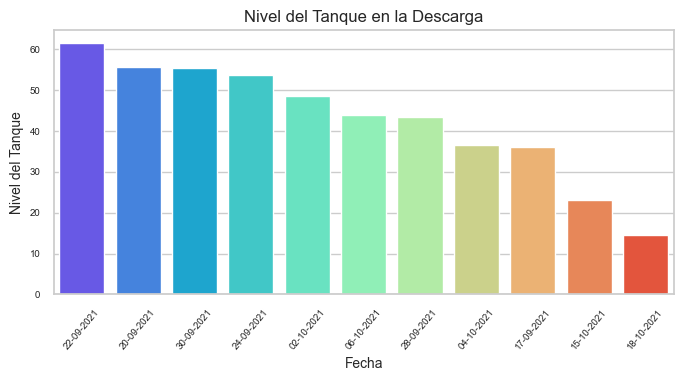

In [49]:
# Graficamos:
fig = plt.figure(figsize=(8,3.5), dpi=100)
ax = fig.gca()
figure=sns.barplot(x='Date',y='Nivel (%)',data=descargas_df,palette=pal)
figure.set_title("Nivel del Tanque en la Descarga",fontsize=12)
plt.xticks(fontsize=7,rotation=50)
plt.yticks(fontsize=7)
plt.xlabel("Fecha", fontsize=10)
plt.ylabel("Nivel del Tanque", fontsize=10)
plt.show()
